In [1]:
import os
import pickle
import datetime
import warnings

import numpy as np
import pandas as pd
from matplotlib.pyplot import rcParams

# import xgboost as xgb
# from xgboost import plot_importance

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
dot_num1 = pd.read_csv(path + 'cst1.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])
dot_num2 = pd.read_csv(path + 'cst2.csv', header = None, names = ['order_date', 'dot', 'company', 'order_num'])

In [3]:
dot_info = pd.read_csv(path + 'dot_1.csv', header = None, names = ['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province', 'city', 'district', 'town', 'village'])

In [4]:
dot_num = pd.concat([dot_num1, dot_num2], ignore_index = True)
len(dot_num)
dot_num['order_date'] = [str(x)[0:4] +'-'+ str(x)[4:6] +'-'+ str(x)[6:] for x in dot_num['order_date']]
dot_num['order_date'] = pd.to_datetime(dot_num['order_date'])

In [5]:
dot_data_tmp = dot_num[dot_num['dot'].isin(dot_info['dot'])]

In [6]:
dot_data_tmp.head()

,order_date,dot,company,order_num
1,2017-09-19,甪直澄北点部,广州优之辰光,1
2,2017-02-28,龙岗碧岭点部,深圳嘉利铧鑫,1
11,2017-02-26,福田梅林点部,深圳晶明（上梅林）,1
12,2017-04-13,寮步东坑点部,东莞鼎立(寮步),1
13,2017-11-25,华强北燕南点部,北京前海润林,1


In [7]:
len(dot_data_tmp['dot'].unique())

2419

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021F81ED8E80>]],
      dtype=object)

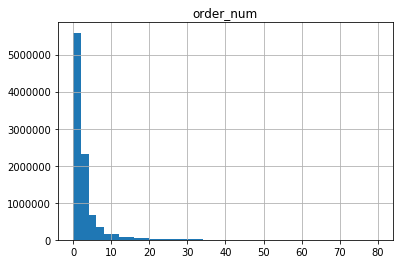

In [16]:
dot_data_tmp.hist(bins = 40, range = (0,80))

In [18]:
len(dot_data_tmp[dot_data_tmp['order_num'] < 20])/len(dot_data_tmp)
len(dot_data_tmp[dot_data_tmp['order_num'] > 40])

76713

In [20]:
dot_data_tmp.loc[dot_data_tmp['order_num'] > 40, ['order_num']] = 40

In [21]:
dot_data_tmp = dot_data_tmp.drop(['company'], axis = 1)

In [22]:
# 按点部和日期对order_num求和
dot_groupby = dot_data_tmp.groupby(['dot', 'order_date']).sum()
dot_groupby.reset_index(inplace = True)

In [23]:
dot_groupby.sort_values(by = 'order_date', inplace = True)
dot_groupby.reset_index(drop = True, inplace = True)
dot_groupby.head()

,dot,order_date,order_num
0,桐乡凤鸣点部,2017-01-01,45
1,珠海白蕉点部,2017-01-01,1
2,常熟海虞点部,2017-01-01,1
3,济南桑梓店点部,2017-01-01,26
4,松江九亭点部,2017-01-01,7


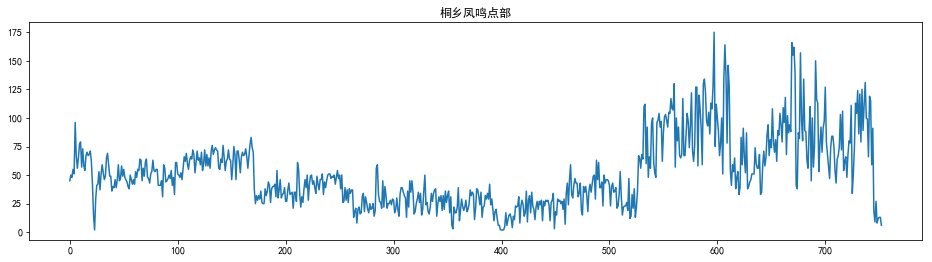

In [24]:
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
tmp = dot_groupby.loc[dot_groupby['dot'] == "桐乡凤鸣点部", 'order_num']
tmp.reset_index(drop = True, inplace = True)
tmp.plot(figsize = (16,4))
plt.title('桐乡凤鸣点部')
plt.show()
# tmp.plot(figsize = (16,4), xlim=(0,21), ylim = (0,60))
# # plt.show()
# tmp.plot(figsize = (16,4), xlim=(400 , 550))
# plt.show()
# tmp.plot(figsize = (16,4), xlim=(630,660), ylim = (0,150))

#### 异常值处理

In [27]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(dot_groupby['dot'].unique()):
    one_dot = dot_groupby.loc[dot_groupby['dot'] == dot]
    check_time = dot_info.loc[dot_info['dot'] == dot, 'check_date']
    one_dot = one_dot[one_dot['order_date'] > check_time.iloc[0]]
    if len(one_dot) == 0:
        continue
    num_median = np.median(one_dot['order_num'])

    # 均值填充异常点
    lp = np.percentile(one_dot['order_num'],25)
    up = np.percentile(one_dot['order_num'],75)
    check_num = up + 1.5 * (up - lp)
    num_mean = np.mean(one_dot['order_num'])
    one_dot.loc[one_dot['order_num'] >= check_num, ['order_num']] = num_mean
    
    # 填充日期，中位数填充缺失值
    one_dot.index = one_dot['order_date']
    one_dot_resample = one_dot.resample('D').asfreq()
    one_dot_resample.drop(['order_date'], axis = 1, inplace = True)
    one_dot_resample.reset_index(inplace = True)
    one_dot_resample['dot'].fillna(dot, inplace = True)
    one_dot_resample['order_num'].fillna(num_median, inplace = True)
    one_dot_resample['dot_id'] = i + 1

    dot_preprocessing = pd.concat([dot_preprocessing, one_dot_resample], axis = 0,ignore_index = True)

In [28]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,order_num,dot_id
0,2017-01-14,桐乡凤鸣点部,4.077537,1
108416,2017-01-14,扬州槐泗点部,3.931826,181
107668,2017-01-14,青岛平度点部,1.386294,180
106918,2017-01-14,南昌高新点部,1.609438,179
106169,2017-01-14,长春二道点部,0.693147,178


In [29]:
dot_data = pd.merge(dot_info, dot_prep, how = 'left', on = 'dot')

In [30]:
dot_data.loc[dot_data['city'].isnull(), ['city']] = dot_data.loc[dot_data['city'].isnull(), ['province']].values
dot_data.loc[dot_data['district'].isnull(), ['district']] = dot_data.loc[dot_data['district'].isnull(), ['city']].values

In [31]:
dot_data.dropna(axis = 0, inplace = True)
dot_data.sort_values(by = 'order_date', ascending = True, inplace = True)

In [32]:
dot_data.head()

,dot,check_date,dot_type,city_code,area,province,city,district,town,village,order_date,order_num,dot_id
447390,哈尔滨道里点部,2017-01-13,大点部,451,华北,黑龙江省,哈尔滨市,道里区,新发镇,东明村,2017-01-14,1.386294,204.0
519474,湖州康山点部,2017-01-13,大点部,572,华东,浙江省,湖州市,吴兴区,康山街道,巴黎春天社区,2017-01-14,2.708050,166.0
329546,光明圳美点部,2017-01-13,大点部,755,华南,广东省,深圳市,光明区,新湖街道,圳美居委会,2017-01-14,4.499810,97.0
220223,大连开发区点部,2017-01-13,大点部,411,华北,辽宁省,大连市,金州区,马桥子街道,岭湾峰尚社区,2017-01-14,1.791759,55.0
129947,常熟沙家浜点部,2017-01-13,大点部,512,华东,江苏省,苏州市,常熟市,沙家浜镇,沙南村,2017-01-14,3.433987,11.0


In [33]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep_1['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    
    return dot_prep_1

def create_feature(data, all_dot):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in all_dot:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [34]:
print("START: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
all_dot = dot_data['dot'].unique()
dot_prep_feature = create_feature(dot_data, all_dot)
print("END: ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

START:  2019-03-20 15:57:07
END:  2019-03-20 16:00:29


In [36]:
dot_prep_feature.columns

Index(['dot', 'check_date', 'dot_type', 'city_code', 'area', 'province',
       'city', 'district', 'town', 'village', 'order_date', 'order_num',
       'dot_id', 'year', 'month', 'day', 'dayofweek', 'dayofyear',
       'weekofyear', 'weekofsun', 'holidays', 'lagging1', 'lagging2',
       'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7', 'rolling3',
       'rolling5', 'rolling7'],
      dtype='object')

In [38]:
# 统计特征
dot_res_tmp = dot_prep_feature.drop(['check_date', 'city', 'district', 'town', 'village'], axis=1)
dot_prep_sta = dot_res_tmp.copy()
dot_prep_dayofweek = dot_prep_sta.groupby(['dot', 'dayofweek'])['order_num'].agg([('week_mean', np.mean), ('week_median', np.median), ('week_min', np.min), ('week_max', np.max), ('week_std', np.std)]).reset_index()
dot_prep_day = dot_prep_sta.groupby(['dot', 'day'])['order_num'].agg([('day_mean', np.mean), ('day_median', np.median), ('day_min', np.min), ('day_max', np.max), ('day_std', np.std)]).reset_index()

dot_prep_tmp = pd.merge(dot_prep_sta, dot_prep_dayofweek, on = ['dot', 'dayofweek'], how = 'left')
dot_prep_stas = pd.merge(dot_prep_tmp, dot_prep_day, on = ['dot', 'day'], how = 'left')

In [39]:
dot_res = pd.concat([dot_prep_stas, pd.get_dummies(dot_prep_stas['dot_type']), pd.get_dummies(dot_prep_stas['area']), pd.get_dummies(dot_prep_stas['province'])], axis = 1)
dot_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
dot_res = dot_res[~dot_res['dot'].isin(dot_res[dot_res['week_std'].isnull()]['dot'].unique())]

In [40]:
dot_res.columns

Index(['dot', 'city_code', 'order_date', 'order_num', 'dot_id', 'year',
       'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun',
       'holidays', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5',
       'lagging6', 'lagging7', 'rolling3', 'rolling5', 'rolling7', 'week_mean',
       'week_median', 'week_min', 'week_max', 'week_std', 'day_mean',
       'day_median', 'day_min', 'day_max', 'day_std', '二级中转场', '大点部', '小点部',
       '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海', '云南省', '内蒙古', '北京', '吉林省',
       '四川省', '天津', '安徽省', '山东省', '山西省', '广东省', '广西', '新疆', '江苏省', '江西省',
       '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省', '甘肃省', '福建省', '贵州省', '辽宁省',
       '重庆', '陕西省', '黑龙江省'],
      dtype='object')

### 存储数据

In [52]:
dot_res.to_csv(path + "dot_res_20190226.csv", encoding = 'GBK')

In [ ]:
train_date = dot_res['order_date'].max() + pd.DateOffset(months = -1)
dot_train = dot_res[dot_res['order_date'] <= train_date]
dot_test = dot_res[dot_res['order_date'] > train_date]

In [ ]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [ ]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

图像到文本的识别OCR